In [26]:
%pylab inline
def figure(name, *args, **kwargs):
    plt.close(name)
    return plt.figure(name, *args, **kwargs)
    
import pandas as pd
from scipy.optimize import curve_fit

import scipy.constants as c

def nom(arr):
    return array([x.n for x in arr])

def unc(arr):
    return array([x.s for x in arr])

FILETYPES = ['pgf', 'png', 'pdf']
def save(name):
    if not EXPORT_FIGS:
        return
    for t in FILETYPES:
        plt.savefig(name + '.' + t, bbox_inches='tight', transparent="True", pad_inches=0)

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['save', 'figure']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [27]:
EXPORT_FIGS=False
if EXPORT_FIGS:
    plt.rc('font', family='serif', size=12) 
    plt.rc('text', usetex='true')
    
plt.rcParams['figure.figsize'] = 7.6, 4.6 # irrelevant for interactive plots
plt.rcParams["legend.columnspacing"] = 0.6

In [28]:
from scipy.signal import find_peaks_cwt
import scipy.signal

## Data from the long Optidos run

Load the data (and do some adjustments)

In [29]:
df = pd.read_table('ganzlangemessung.txt', comment='#', sep=';', )
df.rename(columns={c+'[mm]':c for c in 'xyz'}, inplace=True)
df.set_index(keys=['z', 'x', 'y'], inplace=True)

let's take a look

In [30]:
df.xs(0)

Value  Resolution  Range
x     y                                 
19.75 21.75  0.000052           2      0
      21.90  0.000061           2      0
      22.05  0.000072           2      0
      22.20  0.000086           2      0
      22.35  0.000105           2      0
...               ...         ...    ...
25.00 22.35  0.001846           0      0
      22.20  0.001524           0      0
      22.05  0.001263           1      0
      21.90  0.001066           1      0
      21.75  0.000862           1      0

[1296 rows x 3 columns]

In [31]:
df.xs(0).pivot_table(values='Value', index='y', columns='x').shape

(36, 36)

In [32]:
CORRECTION = 1.857 / 1.243

<Figure size 547.2x331.2 with 0 Axes>

Text(0.5, 0, '$x$ in $\\mathrm{mm}$')

Text(0, 0.5, '$y$ in $\\mathrm{mm}$')

Text(0, 0.5, 'dose rate in $\\mathrm{mGy\\,s}^{-1}$')

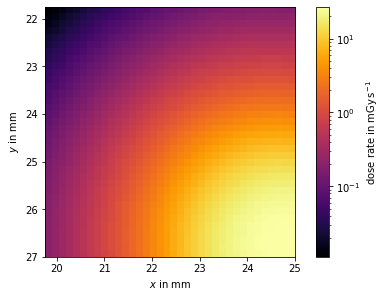

In [47]:
figure('Beam cross section')
extent = [df.xs(0).index.min()[0], df.xs(0).index.max()[0],
          df.xs(0).index.max()[1], df.xs(0).index.min()[1]]
plt.imshow(df.xs(0).pivot_table(values='Value', index='y', columns='x') * 1e3 / 7 * CORRECTION ,
           extent=extent, cmap='inferno', interpolation='none', norm=matplotlib.colors.LogNorm())
cbar = plt.colorbar()

plt.xlabel(r'$x$ in $\mathrm{mm}$')
plt.ylabel(r'$y$ in $\mathrm{mm}$')
cbar.ax.set_ylabel(r'dose rate in $\mathrm{mGy\,s}^{-1}$')

save('../cross-section')

<Figure size 547.2x331.2 with 0 Axes>

Text(0.5, 0, '$x$ in $\\mathrm{mm}$')

Text(0, 0.5, 'dose rate in $\\mathrm{mGy\\, s}^{-1}$')

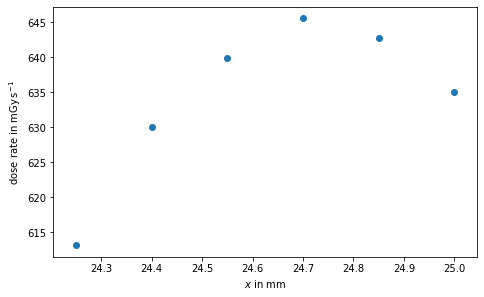

In [48]:
figure('find maximum')
plt.scatter(df.xs(0).index.levels[0][-6:], array(df.groupby('x').Value.sum())[-6:]* 1e3 / 7 * CORRECTION)
# plt.plot(transpose([df.xs(i).groupby('x').Value.sum() for i in range(5)]))
plt.xlabel(r'$x$ in $\mathrm{mm}$')
plt.ylabel(r'dose rate in $\mathrm{mGy\, s}^{-1}$')

save('max_x')

<Figure size 547.2x331.2 with 0 Axes>

Text(0.5, 0, '$y$ in $\\mathrm{mm}$')

Text(0, 0.5, 'dose rate in $\\mathrm{mGy\\, s}^{-1}$')

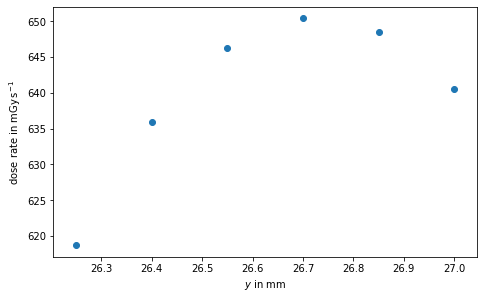

In [49]:
figure('find maximum (y)')
plt.scatter(df.xs(0).index.levels[1][-6:], array(df.groupby('y').Value.sum())[-6:]* 1e3 / 7 * CORRECTION)
# plt.plot(transpose([df.xs(i).groupby('x').Value.sum() for i in range(5)]))
plt.xlabel(r'$y$ in $\mathrm{mm}$')
plt.ylabel(r'dose rate in $\mathrm{mGy\, s}^{-1}$')

save('max_y')

In [36]:
# figure('smoothed')
x = linspace(-1.7, 1.7, 40)
f = exp(-x**2/2) - exp(-1.7)
# plt.plot(convolve(df.xs(0).groupby('x').Value.sum().repeat(20), f)[len(f)-1:(-len(f)+1)])

## Process simulation

In [37]:
fname = 'Fluka/praktikum001_fort.22.lis'

l = []
with open(fname, 'r') as f:
    for i in range(9):
        print(f.readline(), end='')
    for lin in f:
        l.extend([float32(s) for s in lin.split()])
l = array(l)
l = l.reshape((110, 110, 1000))

1
   Cartesian binning n.   1  "FlatDose  " , generalized particle n.  228
      X coordinate: from -1.0000E-01 to  1.0000E+00 cm,  1000 bins ( 1.1000E-03 cm wide)
      Y coordinate: from -1.0000E+00 to  1.0000E+00 cm,   110 bins ( 1.8182E-02 cm wide)
      Z coordinate: from -1.0000E+00 to  1.0000E+00 cm,   110 bins ( 1.8182E-02 cm wide)
      Data follow in a matrix A(ix,iy,iz), format (1(5x,1p,10(1x,e11.4)))

      accurate deposition along the tracks requested
      this is a track-length binning


<Figure size 547.2x331.2 with 0 Axes>

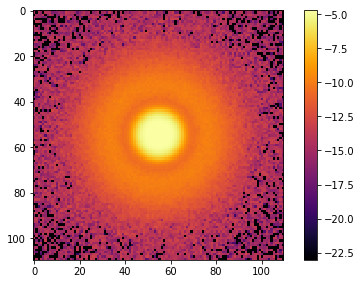

In [38]:
figure('sim')
d = 0
breite = 10
zslice = slice(max(100*d - breite, 0), 100*d + breite)
cs_sim = sum(l[:, :, zslice], axis=2)
plt.imshow(log(1e-10 + cs_sim), cmap='inferno')

plt.colorbar()

In [39]:
def sim_slice(d, breite=0.1, offset=.2):
    frm = max(d - breite, 0) + offset
    to = d + breite + offset
    
    zslice = slice(int((frm + 1)/11 * 1000), int((to + 1)/11 * 1000))
    print(zslice)
    cs_sim = sum(l[:, :, zslice], axis=2)
    return cs_sim / (zslice.stop - zslice.start)

In [40]:
measured_area = l[int(55 - 2.5 * .15 / (2/11)) : int(55 + 33.5 * .15 / (2/11)),
                      int(55 - 2.5 * .15 / (2/11)) : int(55 + 33.5 * .15 / (2/11)),
                      int(1/0.011) : int(5/0.011)]

quot = sum(df.Value) / sum(measured_area) * measured_area.size / df.Value.size
quot

37.204925698303846

slice(445, 463, None)


<Figure size 547.2x331.2 with 0 Axes>

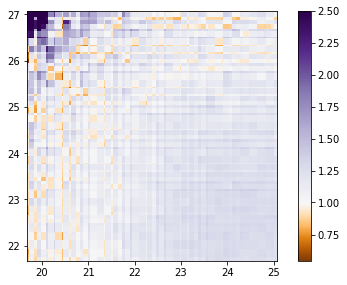

In [41]:
d = 4
offsetx = -0
offsety = -0
cs_s = sim_slice(d, offset=0).repeat(40, 0).repeat(40, 1)[55*40 - 33*33 + offsetx : 55*40 + 33*3 + offsetx,
                                                          55*40 - 33*33 + offsety : 55*40 + 33*3 + offsety]
cs_e = df.xs(d).pivot_table(values='Value', index='y', columns='x').to_numpy().repeat(33, 0).repeat(33, 1)

figure('simul')
lr = cs_s/cs_e * quot
extent = [df.xs(0).index.min()[0] - .075, df.xs(0).index.max()[0] + .075,
          df.xs(0).index.min()[1] - .075, df.xs(0).index.max()[1] + .075]

plt.imshow(lr, cmap='PuOr', extent=extent, norm=matplotlib.colors.DivergingNorm(1, vmax=min(lr.max(), 2.5)))
plt.colorbar()

plt.savefig(f'../ratio_z{d}.pgf', bbox_inches='tight', transparent="True", pad_inches=0)
plt.savefig(f'../ratio_z{d}.png', bbox_inches='tight', transparent="True", pad_inches=0)

<Figure size 547.2x331.2 with 0 Axes>

slice(90, 100, None)


(-0.1, 7)

(-0.008076147277084672, 0.1695990928187781)

Text(0.5, 0, '$r$ in $\\mathrm{mm}$')

Text(0, 0.5, 'normalized dose')

<Figure size 547.2x331.2 with 0 Axes>

slice(172, 190, None)


(-0.1, 7)

(-0.003293638553175396, 0.06916640961668331)

Text(0.5, 0, '$r$ in $\\mathrm{mm}$')

Text(0, 0.5, 'normalized dose')

<Figure size 547.2x331.2 with 0 Axes>

slice(263, 281, None)


(-0.1, 7)

(-0.001229950393922778, 0.025828958272378338)

Text(0.5, 0, '$r$ in $\\mathrm{mm}$')

Text(0, 0.5, 'normalized dose')

<Figure size 547.2x331.2 with 0 Axes>

slice(354, 372, None)


(-0.1, 7)

(-0.0004462989230458267, 0.00937227738396236)

Text(0.5, 0, '$r$ in $\\mathrm{mm}$')

Text(0, 0.5, 'normalized dose')

<Figure size 547.2x331.2 with 0 Axes>

slice(445, 463, None)


(-0.1, 7)

(-0.00016095699161842135, 0.0033800968239868483)

Text(0.5, 0, '$r$ in $\\mathrm{mm}$')

Text(0, 0.5, 'normalized dose')

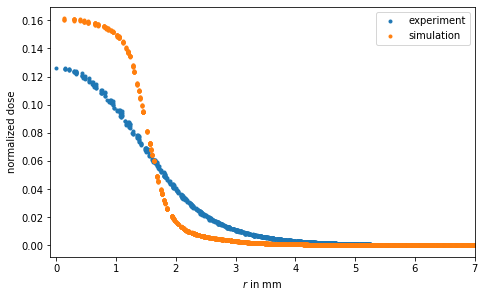

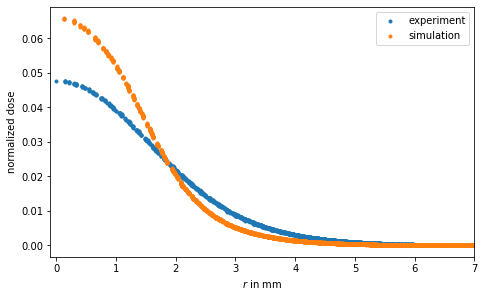

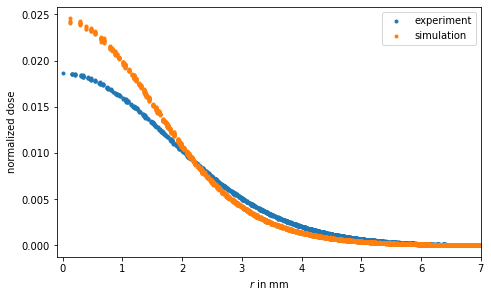

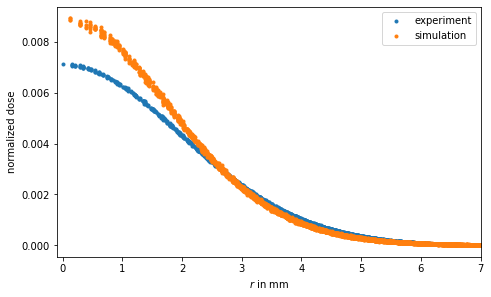

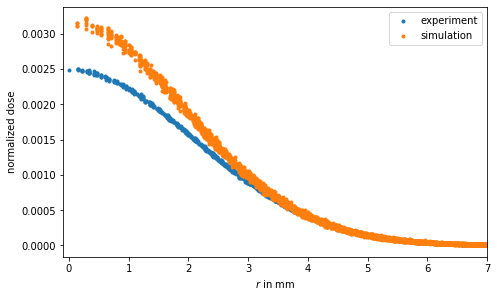

In [42]:
d = 4
offset = .0

for d in range(0, 5):
    figure(f'radial compare at z = {d}')
    center = [24.7, 26.7]
    idx = df.xs(d).index
    radius = sqrt(sum((idx.to_frame() - center)**2, axis=1))
    radial = df.xs(d).set_index(radius)

    plt.scatter(x = radial.index, y = radial.Value, marker='.')

    x = linspace(-10, 10, 110)
    y = linspace(-10, 10, 110)
    X, Y = meshgrid(x, y)
    r = sqrt(X**2 + Y**2)

    cs_sim = sim_slice(d, offset=offset)

    plt.scatter(r.flatten(), cs_sim.flatten() * quot, marker='.')
    plt.xlim(-.1, 7)
    plt.ylim(max(cs_sim.max() * quot, radial.Value.max()) * array([-.05, 1.05]))

    plt.legend(['experiment', 'simulation'])
    plt.xlabel(r'$r$ in $\mathrm{mm}$')
    plt.ylabel('normalized dose')
    save(f'radial_{d}{("_" + str(offset)) if offset != 0 else ""}')

## Measurements and simulation along beam axis

1
   Cartesian binning n.   1  "DepthDose " , generalized particle n.  228
      X coordinate: from  0.0000E+00 to  2.0000E+00 cm,  5000 bins ( 4.0000E-04 cm wide)
      Y coordinate: from -2.5000E+00 to  2.5000E+00 cm,     1 bins ( 5.0000E+00 cm wide)
      Z coordinate: from -2.5000E+00 to  2.5000E+00 cm,     1 bins ( 5.0000E+00 cm wide)
      Data follow in a matrix A(ix,iy,iz), format (1(5x,1p,10(1x,e11.4)))

      accurate deposition along the tracks requested
      this is a track-length binning


array([1.6225e-05, 1.5765e-05, 1.5885e-05, ..., 7.9611e-09, 8.0437e-09,
       8.3994e-09], dtype=float32)

<Figure size 547.2x331.2 with 0 Axes>

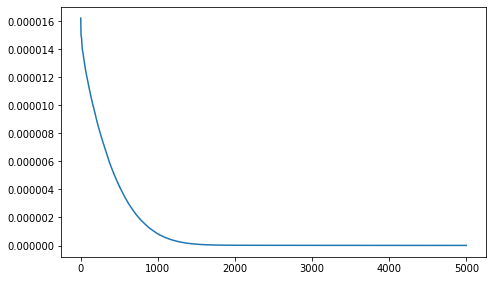

In [43]:
fname = 'Fluka/praktikum001_fort.21.lis'

tiefe = []
with open(fname, 'r') as f:
    for i in range(9):
        print(f.readline(), end='')
    for lin in f:
        tiefe.extend([float32(s) for s in lin.split()])
tiefe = array(tiefe)
tiefe
figure('tiefe sim')
plt.plot(tiefe)

In [44]:
tf = pd.read_table('tiefenochbesser.txt', comment='#', sep=';', )
tf.rename(columns={c+'[mm]':c for c in 'xyz'}, inplace=True)
tf.set_index(keys=['z'], inplace=True)

In [45]:
def inv_sq(x, x0, a):
    return a / (x - x0)**2

<Figure size 547.2x331.2 with 0 Axes>

array([-1.31684473, 48.65768438])

Text(0.5, 0, '$z$ in $\\mathrm{mm}$')

Text(0, 0.5, 'dose rate in $\\mathrm{mGy\\,s}^{-1}$')

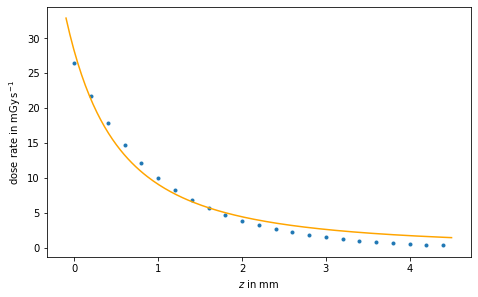

In [46]:
figure('depth')
plt.scatter(tf.index, tf.Value* 1e3 / 20 * CORRECTION, marker='.')

popt, pcov = curve_fit(inv_sq, tf.index, tf.Value* 1e3 / 20 * CORRECTION, p0=[-0.2, 0.1])
popt
X = linspace(tf.index.min() - .1, tf.index.max() + .1, 200)
plt.plot(X, inv_sq(X, *popt), color='orange')
# plt.yscale('log')
plt.xlabel(r'$z$ in $\mathrm{mm}$')
plt.ylabel(r'dose rate in $\mathrm{mGy\,s}^{-1}$')
save('depth')